##GDRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Data5_fix_normal

/content/drive/MyDrive/Data5_fix_clahe


In [ ]:
pwd

'/content/drive/MyDrive/Data5_fix_clahe'

In [ ]:
image_paths=paths.list_images("/content/drive/MyDrive/Data5_fix_normal/")
gambar = []
label = []

##Library

In [ ]:
from PIL import Image
import numpy as np
import os
from imutils import paths
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import tensorflow_addons as tfa

##Pre-processing

In [ ]:
from sklearn import preprocessing
for images in image_paths:
  image = Image.open(images).convert('RGB')
  image = np.array(image.resize((128,128))) / 255.0

  gambar.append(image)
  labels=images.split(os.path.sep)[-2]
  label.append(labels)

In [ ]:
# cek jumlah citra dan dimensi
temp = np.array(gambar)
print(temp.shape)

(12337, 128, 128, 3)


In [ ]:
# cek label kelas
temp2=np.array(label)
print(temp2.shape)
print(label)

(12337,)
['COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID

In [ ]:
#untuk rgb
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
label = lb.fit_transform(label)
print(label)

[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(temp, np.array(label), test_size=0.2, random_state=0)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(8882, 128, 128, 3)
(987, 128, 128, 3)
(2468, 128, 128, 3)
(8882, 5)
(987, 5)
(2468, 5)


##Model

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
!pip install vit-keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def mobilenet(input_shape, n_classes):
  MobileNet_MODEL=tf.keras.applications.mobilenet.MobileNet(
    input_shape=(input_shape),
    include_top=False,
    weights='imagenet')

  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  prediction_layer = tf.keras.layers.Dense(n_classes, activation='Softmax')

  model = tf.keras.Sequential([
    MobileNet_MODEL,
    global_average_layer,
    prediction_layer
  ])
  return model

In [ ]:
# Create the teacher
from vit_keras import vit,utils
image_size=128
teacher = vit.vit_b16(
    image_size=image_size,
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    activation = 'softmax',
    classes=5)
# Create the student
student = mobilenet((128,128,3), 5)

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 8, 8
  UserWarning,


##Training

In [ ]:
# Train teacher as usual
teacher.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

# Train and evaluate teacher on data.
teacher.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=16)
teacher.evaluate(X_test, Y_test)

Epoch 1/100
139/139 [==============================] - 108s 543ms/step - loss: 0.6188 - accuracy: 0.7543 - val_loss: 0.3082 - val_accuracy: 0.8815
Epoch 2/100
139/139 [==============================] - 72s 517ms/step - loss: 0.3075 - accuracy: 0.8785 - val_loss: 0.3135 - val_accuracy: 0.8734
Epoch 3/100
139/139 [==============================] - 72s 517ms/step - loss: 0.2443 - accuracy: 0.9033 - val_loss: 0.2916 - val_accuracy: 0.8926
Epoch 4/100
139/139 [==============================] - 72s 517ms/step - loss: 0.2034 - accuracy: 0.9147 - val_loss: 0.3434 - val_accuracy: 0.8875
Epoch 5/100
139/139 [==============================] - 72s 517ms/step - loss: 0.1662 - accuracy: 0.9306 - val_loss: 0.2811 - val_accuracy: 0.9078
Epoch 6/100
139/139 [==============================] - 72s 516ms/step - loss: 0.1448 - accuracy: 0.9395 - val_loss: 0.3555 - val_accuracy: 0.8997
Epoch 7/100
139/139 [==============================] - 72s 517ms/step - loss: 0.1186 - accuracy: 0.9514 - val_loss: 0.3459 

[0.9054877758026123, 0.8901944756507874]

In [ ]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
history = distiller.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=16)

# Evaluate student on test dataset
distiller.evaluate(X_test, Y_test)


Epoch 1/100
139/139 [==============================] - 47s 273ms/step - accuracy: 0.8128 - student_loss: 0.4830 - distillation_loss: 2.7293e-04 - val_accuracy: 0.4752 - val_student_loss: 1.4638
Epoch 2/100
139/139 [==============================] - 37s 267ms/step - accuracy: 0.9373 - student_loss: 0.1677 - distillation_loss: 9.7140e-05 - val_accuracy: 0.6363 - val_student_loss: 1.0794
Epoch 3/100
139/139 [==============================] - 37s 266ms/step - accuracy: 0.9795 - student_loss: 0.0771 - distillation_loss: 3.8523e-05 - val_accuracy: 0.7852 - val_student_loss: 0.5956
Epoch 4/100
139/139 [==============================] - 37s 267ms/step - accuracy: 0.9945 - student_loss: 0.0365 - distillation_loss: 1.4019e-05 - val_accuracy: 0.8926 - val_student_loss: 0.3265
Epoch 5/100
139/139 [==============================] - 37s 265ms/step - accuracy: 0.9968 - student_loss: 0.0230 - distillation_loss: 7.5265e-06 - val_accuracy: 0.8977 - val_student_loss: 0.3249
Epoch 6/100
139/139 [=========

[0.9059967398643494, 1.3069274425506592]

In [ ]:
distiller.student.save_weights('/content/drive/MyDrive/model/model_5.h5')

In [ ]:
#Train student as doen usually
#student_scratch.compile(
#    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0001),
#    loss=keras.losses.CategoricalCrossentropy(),
#    metrics=['accuracy'],
#)

# Train and evaluate student trained from scratch.
#student_scratch.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=64)
#student_scratch.evaluate(X_test, Y_test)

##Akurasi&Loss

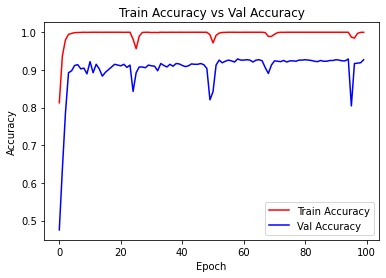

In [ ]:
import matplotlib.pyplot as plt
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy', color='red', )
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='blue', )
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("gamma_akurasi.jpg")
plt.show()

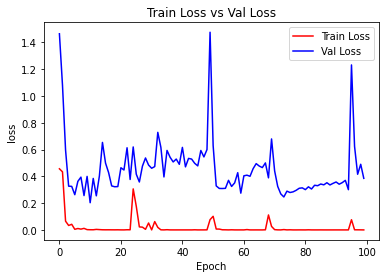

In [ ]:
import matplotlib.pyplot as plt
plt.title('Train Loss vs Val Loss')
plt.plot(history.history['student_loss'], label='Train Loss', color='red', )
plt.plot(history.history['val_student_loss'], label='Val Loss', color='blue', )
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig("loss_gamma.jpg")
plt.show()

In [ ]:
saved_model = Distiller(student=student, teacher=teacher)
saved_model.student.load_weights('/content/drive/MyDrive/model/model_5.h5')

##Clasification report

In [ ]:
#confusion matrix
from sklearn.metrics import classification_report
print("[INFO] evaluating network...")
predictions = saved_model.student.predict(X_test)
target_names=list(map(str,lb.classes_))
print(classification_report(Y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=target_names, digits=4))

[INFO] evaluating network...
              precision    recall  f1-score   support

    COVID-19     0.9868    0.9796    0.9832       686
      Normal     0.9828    0.9933    0.9880       748
          PB     0.7973    0.8414    0.8187       561
          PV     0.7049    0.6456    0.6740       333
         TBC     1.0000    0.9571    0.9781       140

    accuracy                         0.9060      2468
   macro avg     0.8944    0.8834    0.8884      2468
weighted avg     0.9052    0.9060    0.9053      2468



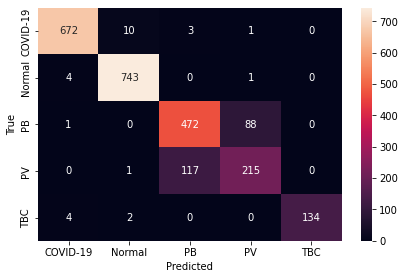

In [ ]:
import sklearn.metrics as metrics
import seaborn as sn
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(Y_test.argmax(axis=1),predictions.argmax(axis=1))
x_axis_labels = ['COVID-19','Normal','PB','PV', 'TBC']
y_axis_labels = ['COVID-19','Normal','PB','PV','TBC']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig("gamma_confusion.jpg")
plt.show()